# Lab 2: Clustering

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD2"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L2_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

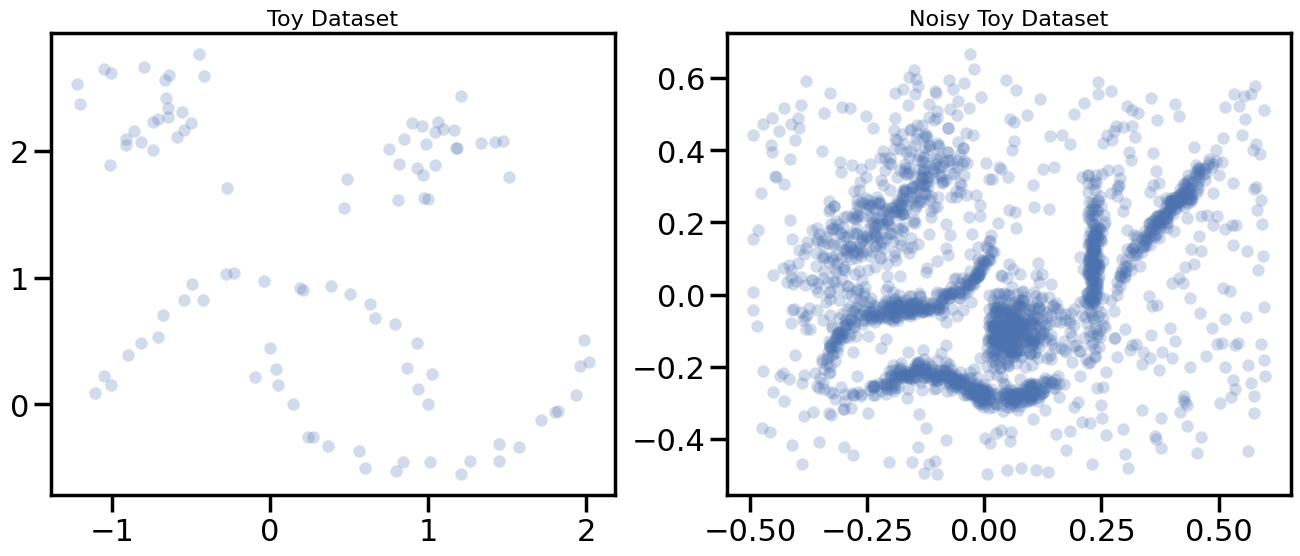

In [3]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

## Aglomerative Single Linkage clustering

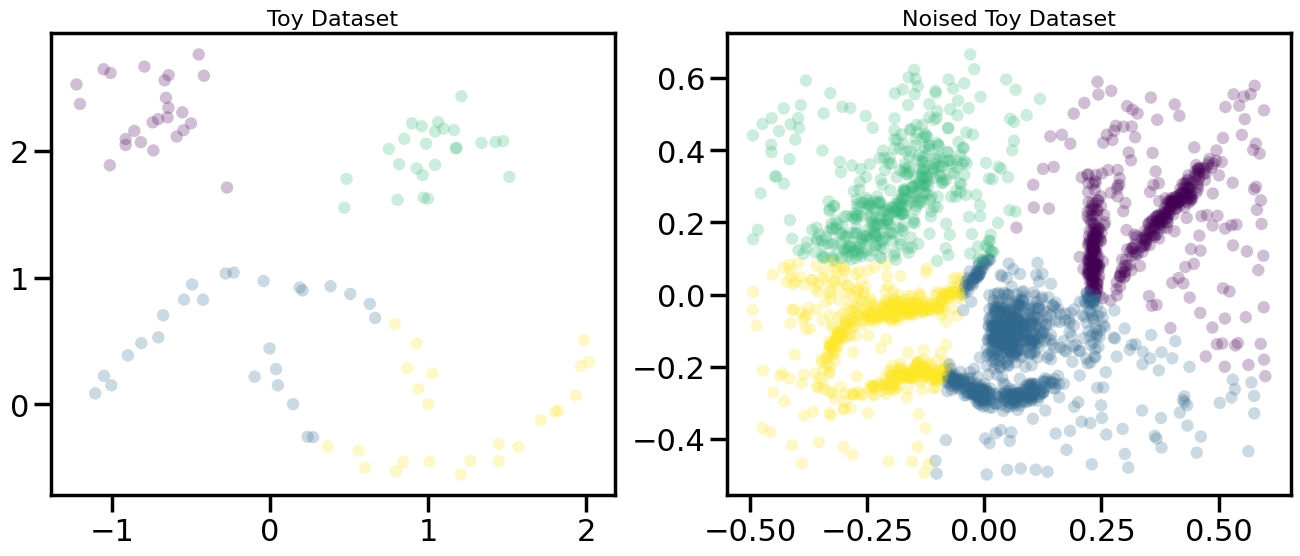

In [4]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [6]:
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance
import numpy as np
import seaborn as sns
from tqdm import tqdm

class my_SingleLinkageAglomerativeClustering():
    def __init__(self, metric="euclidean", n_clusters=3):
        """
        Attributes:
        ----------
        metric_: {"euclidean", "precomputed"}
            The distance metric to be used.
            If "precomputed", X is expected to be a distance matrix.
        n_clusters: int
            Number of clusters to return.
        linkage_matrix_: (n-1, 4) np.array
            The linkage matrix (used to create dendrograms).
        labels_: np.array
            Label assignments for each point.
        hierarchy_: list of np.array
            Labels at each level (number of clusters).
            hierarchy_[0] = np.array(list(range(n))).
        """
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None

    def fit(self, X):
        """
        Fit the hierarchical clustering on the data.

        Parameters:
        -----------
        X: np.array, shape (n_samples, n_features) or precomputed distance matrix
            Input data matrix.

        Returns:
        --------
        self: SingleLinkageAgglomerativeClustering
            Fitted model with labels and linkage matrix.
        """
        # Compute distance matrix if not precomputed
        if self.metric_ != "precomputed":
            self.distance_matrix_ = distance.cdist(X, X, metric=self.metric_)
            np.fill_diagonal(self.distance_matrix_, np.inf)
        else:
            self.distance_matrix_ = X
        
        num_samples = self.distance_matrix_.shape[0]
        self.labels_ = np.arange(num_samples)
        self.hierarchy_ = [np.copy(self.labels_)]
        self.linkage_matrix_ = np.zeros((num_samples - 1, 4))

        # Perform clustering steps
        for step in tqdm(range(num_samples - 1)):
            # Find the closest pair of clusters
            min_dist = np.min(self.distance_matrix_)
            idx_min_dist = np.unravel_index(np.argmin(self.distance_matrix_, axis=None), 
                                            self.distance_matrix_.shape)

            # Get the number of samples in each cluster to merge
            ni_and_nj = [1, 1]
            for k in range(2):
                if idx_min_dist[k] >= num_samples:
                    ni_and_nj[k] = self.linkage_matrix_[idx_min_dist[k] - num_samples, 3]

            # Update linkage matrix
            self.linkage_matrix_[step, :] = [idx_min_dist[0], idx_min_dist[1], min_dist, sum(ni_and_nj)]

            # Update labels and hierarchy
            new_cluster_label = num_samples + step
            self.labels_[self.labels_ == idx_min_dist[0]] = new_cluster_label
            self.labels_[self.labels_ == idx_min_dist[1]] = new_cluster_label
            self.hierarchy_.append(np.copy(self.labels_))

            # Update distance matrix
            dist_of_merged = np.minimum(self.distance_matrix_[:, idx_min_dist[0]],
                                        self.distance_matrix_[:, idx_min_dist[1]])
            self.distance_matrix_ = np.hstack((self.distance_matrix_,
                                               np.full((self.distance_matrix_.shape[0], 1), np.inf)))
            self.distance_matrix_ = np.vstack((self.distance_matrix_,
                                               np.full((1, self.distance_matrix_.shape[1]), np.inf)))
            self.distance_matrix_[:-1, -1] = dist_of_merged
            self.distance_matrix_[-1, :-1] = dist_of_merged
            self.distance_matrix_[idx_min_dist, :] = np.inf
            self.distance_matrix_[:, idx_min_dist] = np.inf

        self.labels_ = self.hierarchy_[num_samples - self.n_clusters_]

        return self

    def plot_dendrogram(self, ax=None, leaf_font_size=12, y_font_size=15):
        """
        Plot the dendrogram of the hierarchical structure using self.linkage_matrix_.

        Parameters:
        -----------
        ax: matplotlib axis object, optional
            Axis to plot the dendrogram on. If None, a new figure is created.
        leaf_font_size: int, optional (default=12)
            Font size for leaf labels.
        y_font_size: int, optional (default=15)
            Font size for y-axis labels.
        """
        # Set colors for the dendrogram
        colors_dendro = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255))
                         for r, g, b in sns.color_palette("husl", self.n_clusters_)]
        
        # Associate cluster colors with each index
        D_leaf_colors = {str(key): None for key in range(self.distance_matrix_.shape[0])}
        clust_names = list(set(self.labels_))
        for i, clust in enumerate(clust_names):
            idxs_this_clust = [str(idx) for idx in np.where(self.labels_ == clust)[0]]
            for key in idxs_this_clust:
                D_leaf_colors[key] = colors_dendro[i]

        link_cols = {}
        for i, i12 in enumerate(self.linkage_matrix_[:, :2].astype(int)):
            c1, c2 = (link_cols[x] if x > len(self.linkage_matrix_)
                      else D_leaf_colors[str(x)] for x in i12)
            link_cols[i + 1 + len(self.linkage_matrix_)] = c1 if c1 == c2 else "#808080"
        
        dendrogram(self.linkage_matrix_, link_color_func=lambda x: link_cols[x], 
                   leaf_font_size=leaf_font_size, ax=ax)


Apply the method to our toy datasets

100%|██████████| 99/99 [00:00<00:00, 30712.73it/s]


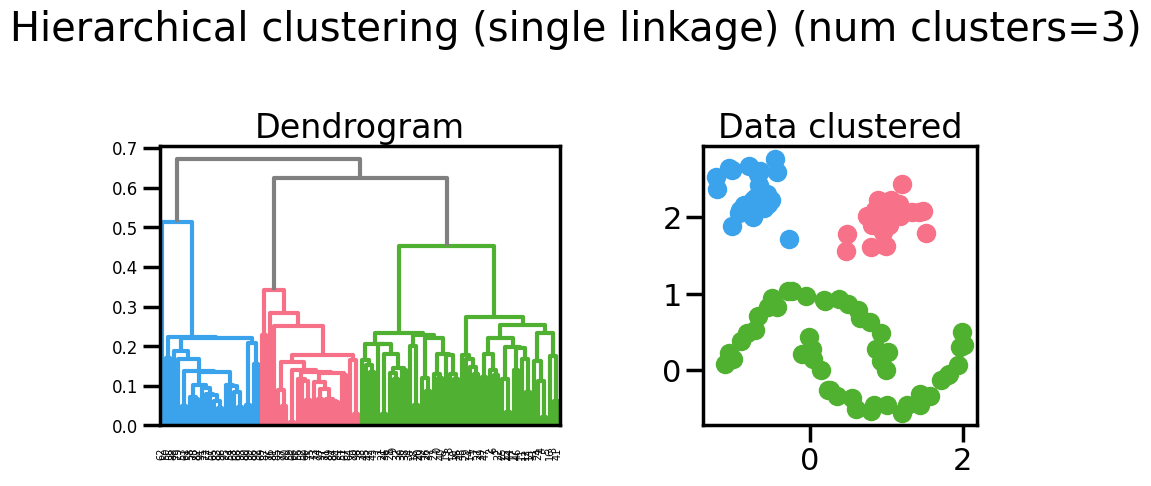

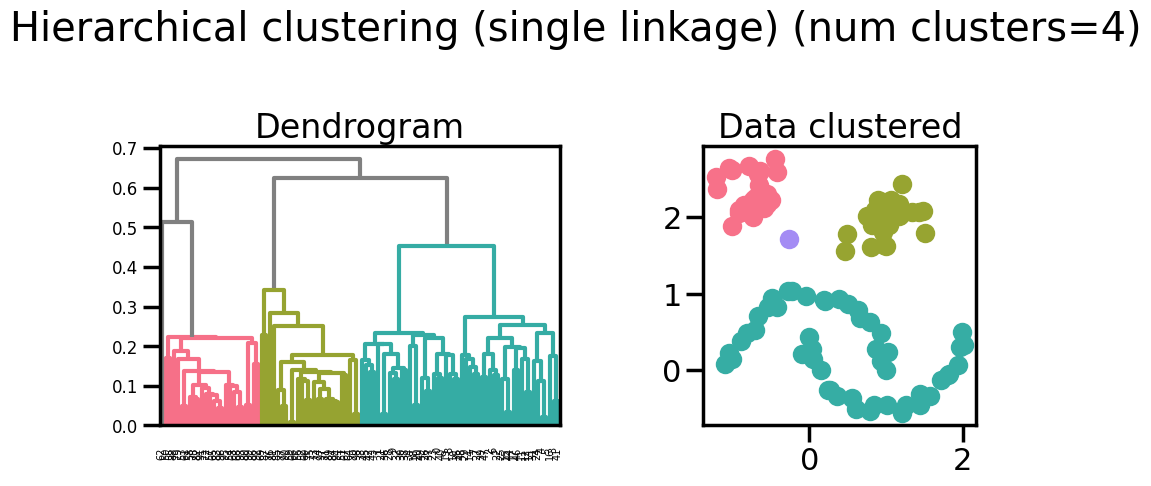

In [16]:
data_tested = [test_data_0]
data_names_plots = ['test_data_0']
n_cluster_tested = [3, 4]

for k, X in enumerate(data_tested):
    for n_cluster in n_cluster_tested:
        this_clust_test_1 = my_SingleLinkageAglomerativeClustering(n_clusters=n_cluster)
        this_clust_test_1.fit(X)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle("Hierarchical clustering (single linkage)"+\
                    f" (num clusters={this_clust_test_1.n_clusters_})")
        this_clust_test_1.plot_dendrogram(ax=axs[0], leaf_font_size=12)
        axs[0].set_title("Dendrogram")
        axs[0].tick_params(axis='y', labelsize=12)
        axs[0].tick_params(axis='x', labelsize=7)
        axs[1].set_aspect('equal')
        for i, clust in enumerate(list(set(this_clust_test_1.labels_))):
            idx_samples_this_clust = np.where(this_clust_test_1.labels_ == clust)[0]
            axs[1].scatter(X[idx_samples_this_clust, 0], X[idx_samples_this_clust, 1],
                        color=sns.color_palette("husl", this_clust_test_1.n_clusters_)[i])
        axs[1].set_title("Data clustered")
        fig.tight_layout();


=> The algorithm outperforms K-means by accurately identifying the four expected clusters. However, it still requires manually specifying the number of clusters (or the cutting threshold). DBSCAN will address this limitation.

Try the different linkage methods implemented in `sklearn`  and comment

100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


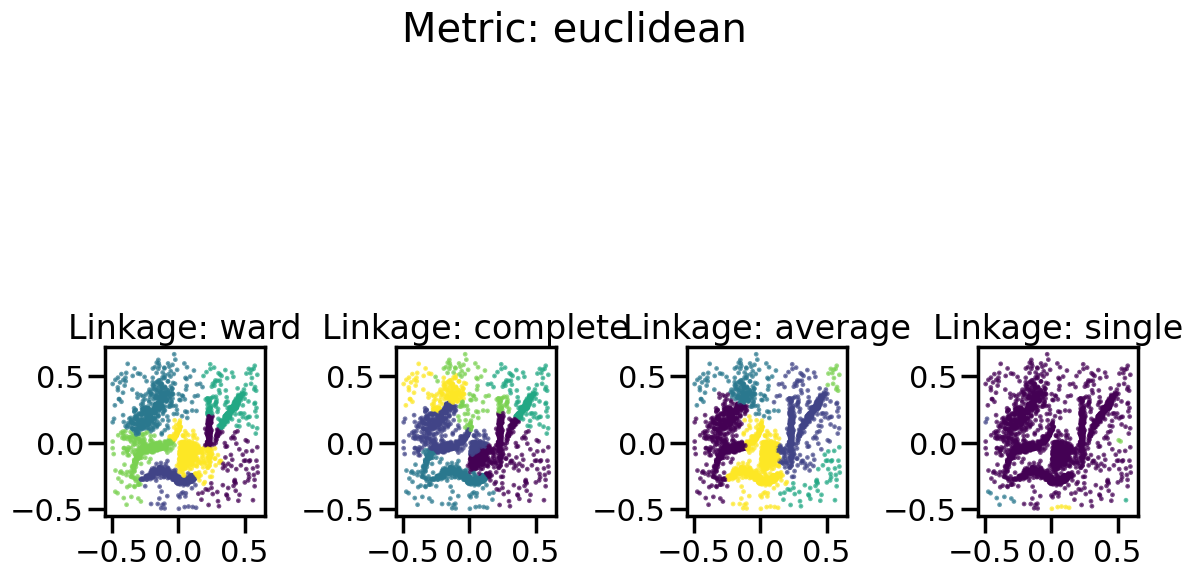

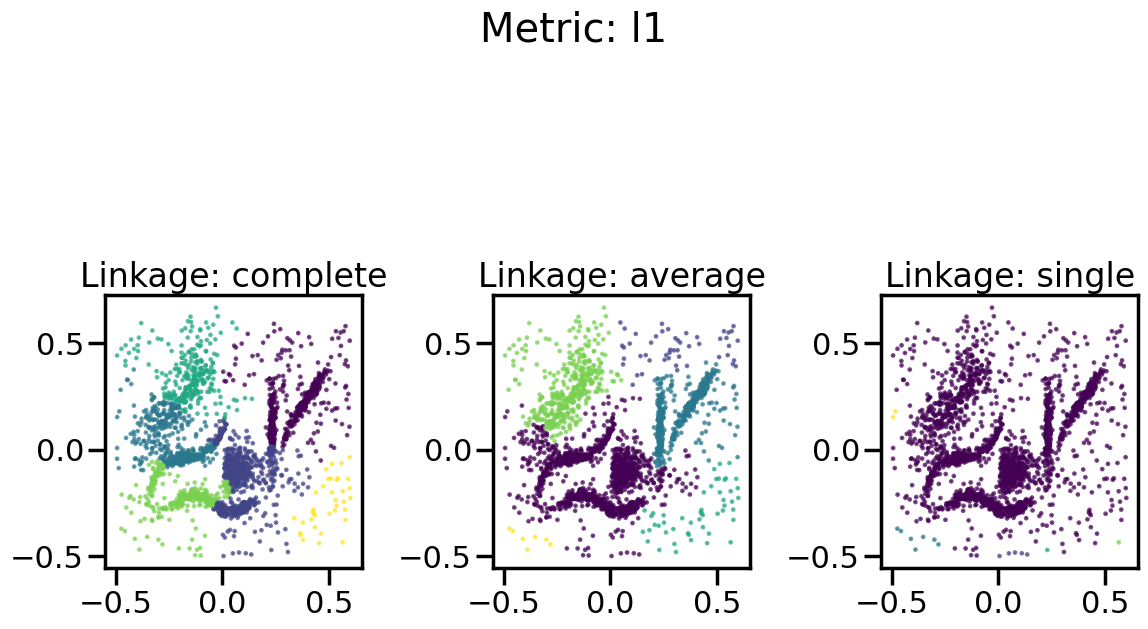

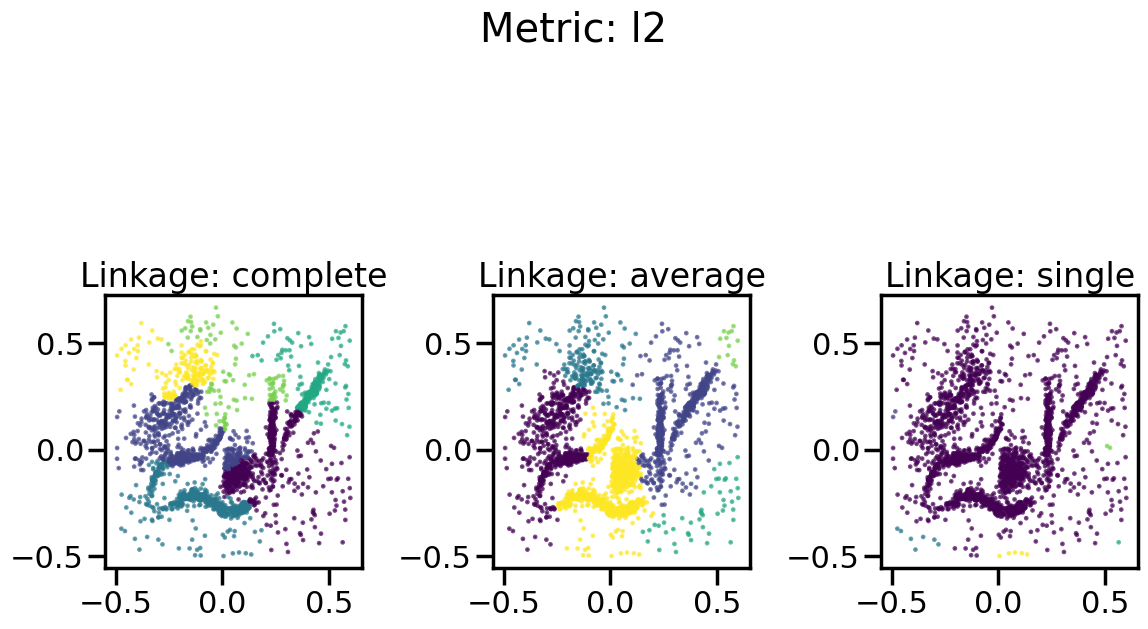

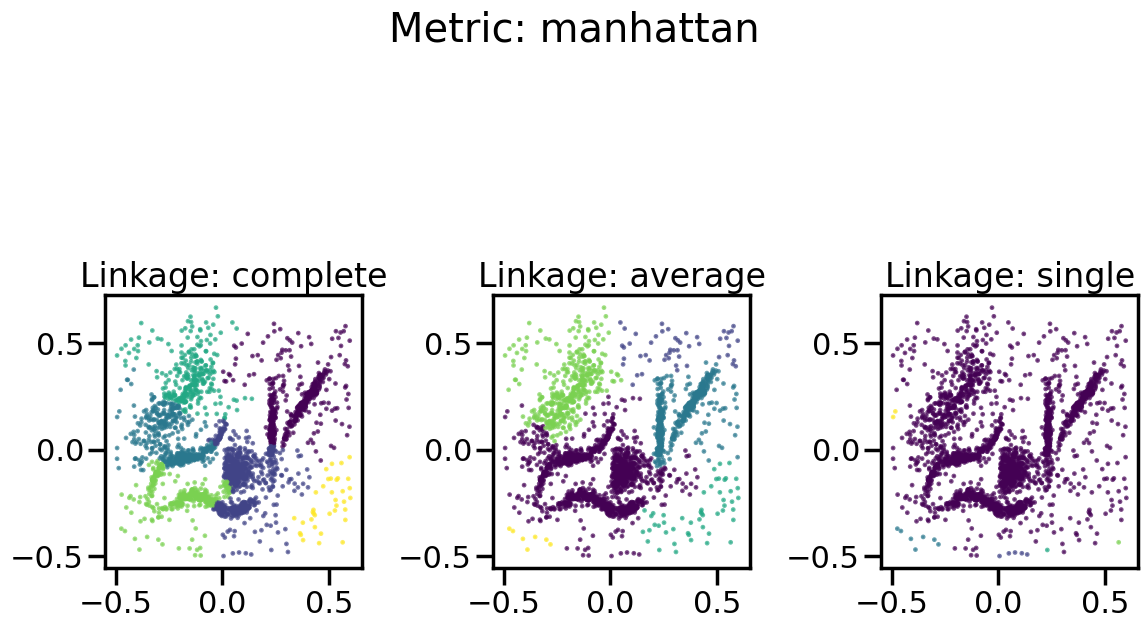

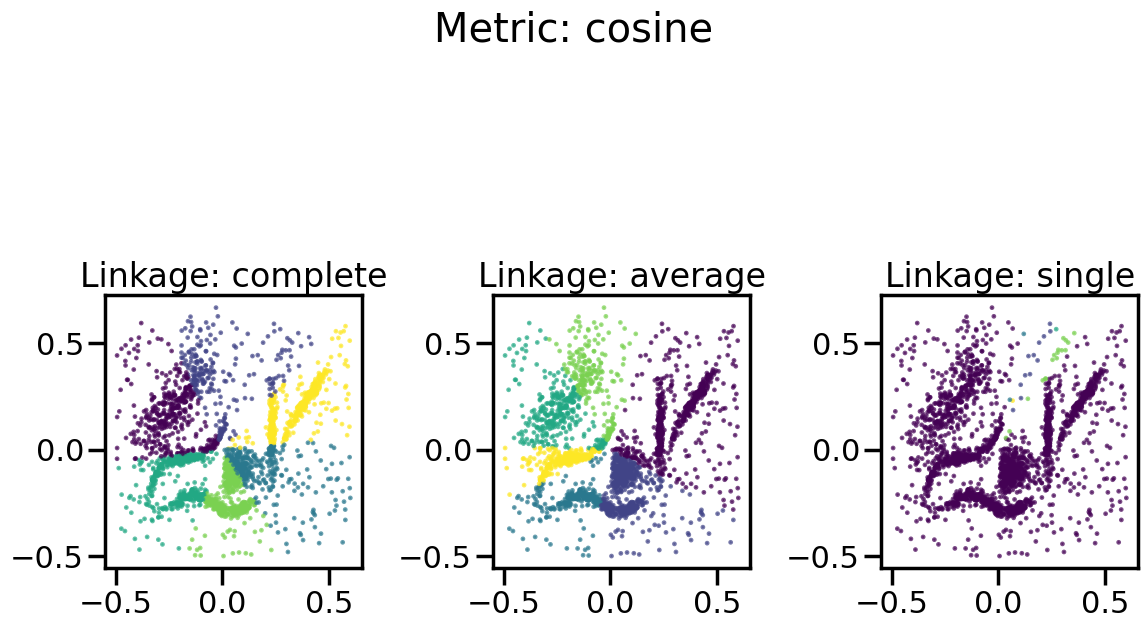

In [25]:
from sklearn.cluster import AgglomerativeClustering

# data_tested = [test_data_0, test_data_1]
# data_names_plots = ['test_data_0', 'test_data_1']
data_tested = [test_data_1]
data_names_plots = ['test_data_1']
n_clusters_tested = [6]

linkage_tested = ['ward', 'complete', 'average', 'single']
metric_tested = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

for points in data_tested:
    for n_clusters in n_clusters_tested:

        for metric in tqdm(metric_tested):
            if metric == 'euclidean':
                this_linkage_tested = linkage_tested
            else:
                this_linkage_tested = [e for e in linkage_tested if e != 'ward'] #documentation tells us to
            n = len(this_linkage_tested)
            n_row_plot = 1 #int(np.sqrt(n))
            n_col_plot = n #n // n_row_plot + 1 * (n%n_row_plot != 0)
            fig, axs = plt.subplots(n_row_plot, n_col_plot, figsize=(12,8)) #figsize=(min(n_col_plot*3, 9), min(n_row_plot*3, 9)) )
            fig.suptitle("Metric: "+metric)

            for l, linkage in enumerate(this_linkage_tested):

                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
                agg_clustering.fit(points)

                idx_ax_plot = l #(l//n_col_plot, l%n_col_plot) if (n_row_plot>1 and n_col_plot>1) else l
                axs[idx_ax_plot].set_aspect('equal')
                axs[idx_ax_plot].scatter(points[:, 0], points[:, 1], s=2, alpha=.7,
                                                         c=agg_clustering.labels_, cmap='viridis')
                axs[idx_ax_plot].set_title("Linkage: "+linkage)
            fig.tight_layout();



=> **To determine the most suitable metric and linkage method, one option would be to conduct a grid search. This process involves testing various combinations of metrics and linkages to minimize intra-cluster distances (within clusters) while maximizing inter-cluster distances (between clusters). However, this approach may not be ideal for our case, as the data's complexity presents specific challenges.**

**In fact, the clustering algorithms available in the scikit-learn library struggle with datasets that contain complex, non-convex shapes or intertwined clusters. This is especially problematic when using the single linkage method, which tends to perform poorly in these situations. The reason is that when data points are densely packed, single linkage often connects clusters based on minimal distances between points, regardless of the actual structure of the clusters. As a result, many points are absorbed into the main cluster, leaving only a few outliers ungrouped, leading to unsatisfactory clustering results.**

**To better address these challenges, density-based clustering methods like DBSCAN (Density-Based Spatial Clustering of Applications with Noise) are more appropriate. DBSCAN can effectively handle clusters of arbitrary shapes and densities, making it more robust in scenarios where traditional linkage-based methods fail to separate complex cluster patterns.**



## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

100%|██████████| 3/3 [00:00<00:00, 54.79it/s]


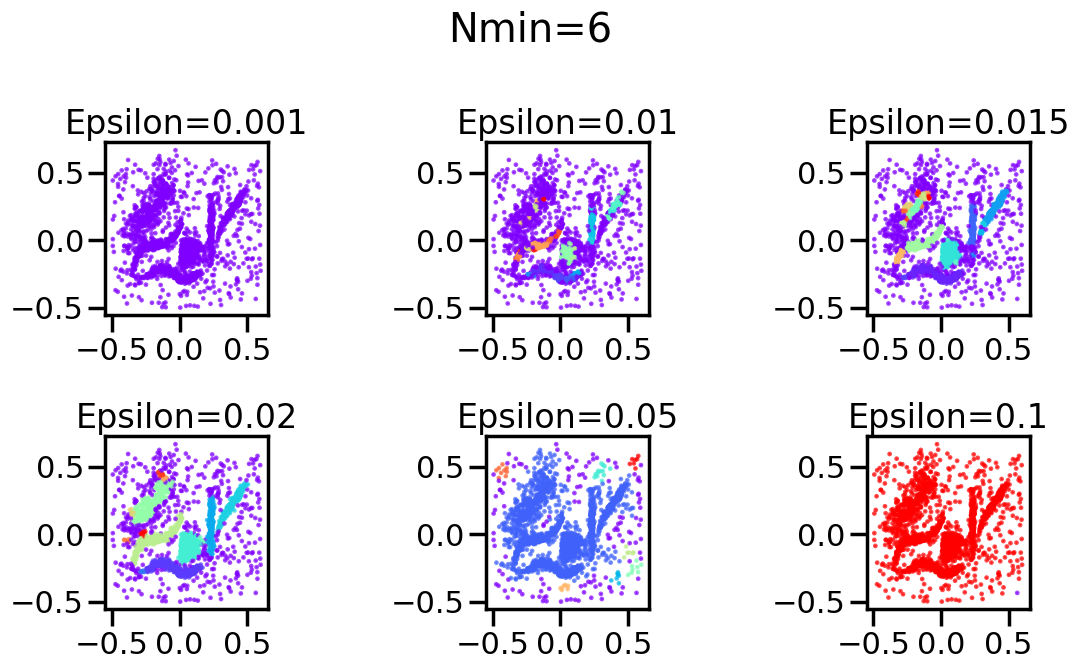

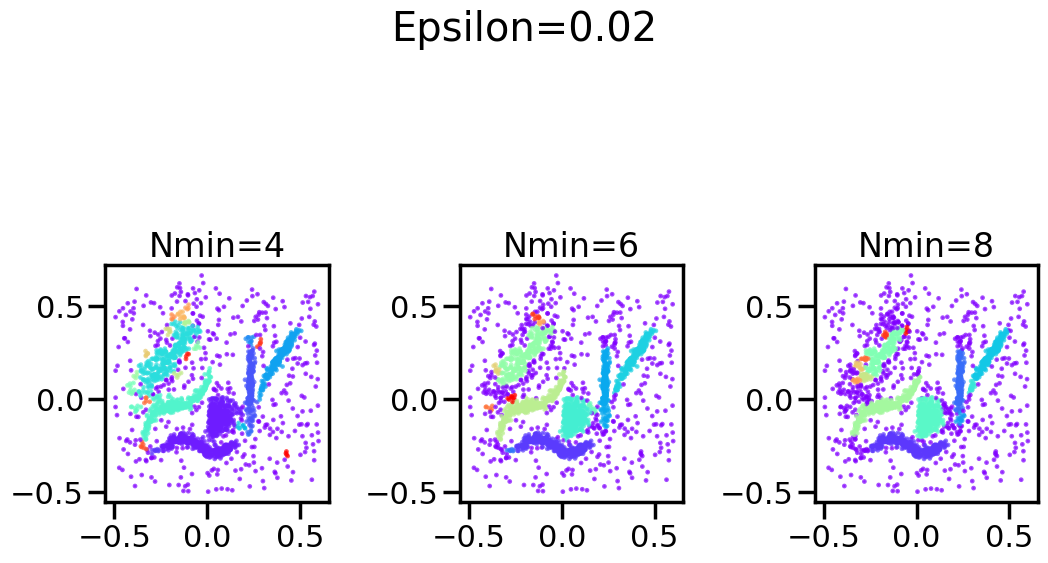

In [31]:
from sklearn.cluster import DBSCAN

points = test_data_1
eps_tested = [0.001, 0.010, 0.015, 0.02, 0.05,0.1]
min_samples_tested = [6]

for min_samples in min_samples_tested:
    n_row_plot, n_col_plot = 2, 3
    fig, axs = plt.subplots(n_row_plot, n_col_plot, figsize=(12, 7) )
    fig.suptitle("Nmin="+str(min_samples))

    for l, eps in enumerate(tqdm(eps_tested)):

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(points)

        idx_ax_plot = (l//n_col_plot, l%n_col_plot) if (n_row_plot>1 and n_col_plot>1) else l
        axs[idx_ax_plot].set_aspect('equal')
        axs[idx_ax_plot].scatter(points[:, 0], points[:, 1], s=2, alpha=.7,
                                 c=cluster_labels, cmap='rainbow')
        axs[idx_ax_plot].set_title("Epsilon="+str(eps))
    fig.tight_layout()

eps_tested = [0.02]
min_samples_tested = [4,6,8]

for eps in eps_tested:
    n_row_plot, n_col_plot = 1, len(min_samples_tested)
    fig, axs = plt.subplots(n_row_plot, n_col_plot, figsize=(11, 7) )
    fig.suptitle("Epsilon="+str(eps))

    for l, min_samples in enumerate(tqdm(min_samples_tested)):

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(points)

        idx_ax_plot = (l//n_col_plot, l%n_col_plot) if (n_row_plot>1 and n_col_plot>1) else l
        axs[idx_ax_plot].set_aspect('equal')
        axs[idx_ax_plot].scatter(points[:, 0], points[:, 1], s=2, alpha=.7,
                                 c=cluster_labels, cmap='rainbow')
        axs[idx_ax_plot].set_title("Nmin="+str(min_samples))
    fig.tight_layout()

=> 
**Both the parameters epsilon (ε) and Nmin (minimum number of points) significantly influence the quality of clustering in DBSCAN.**

**For epsilon, the effect is particularly noticeable at the extremes. A very low epsilon results in most points being isolated, as the algorithm treats them as noise due to the lack of nearby neighbors. On the other hand, a very high epsilon causes nearly all points to be connected, leading to a single large cluster that loses meaningful structure. Gradually increasing epsilon from a small value like 0.01 reduces the number of clusters, and there is a sweet spot around 0.02 where the clusters are well-defined.**

**The Nmin parameter controls how strict the algorithm is in forming clusters. A higher Nmin means that more neighboring points are required for a point to be considered a core point. As Nmin increases, fewer points qualify as core points, leading to thinner and more refined clusters. This reflects a greater constraint on forming dense regions, which can help avoid loosely grouped points from being clustered together.**


One way to fine tune parameters is to use the Elbow method of k-NN, with k=Nmin. At the crook of the elbow, the distance will be the chosen epsilon.

Best epsilon :  0.019183855461704022


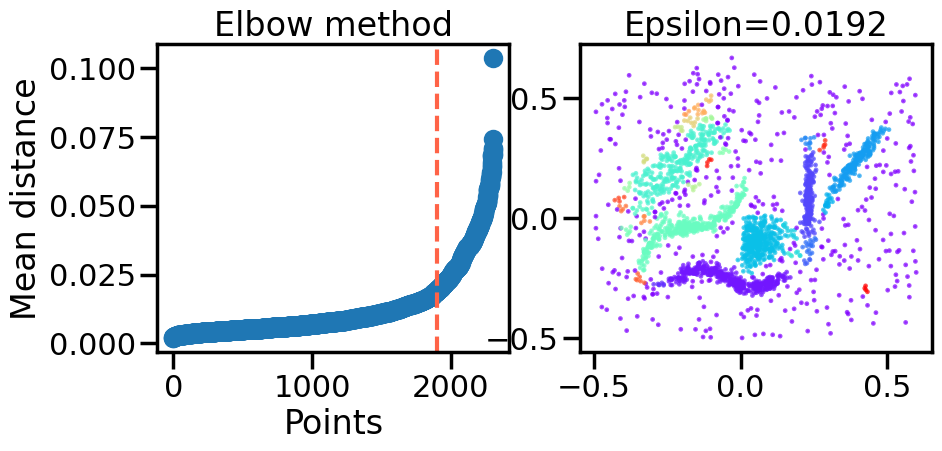

In [32]:
from sklearn.neighbors import NearestNeighbors

Nmin = 6
neigh = NearestNeighbors(n_neighbors=Nmin)
neigh.fit(points)
distances = neigh.kneighbors(points)[0] #distances to neighbors
distances = np.mean(distances,axis=1)
dtype = [('idx', int), ('dist', float)]
sorted_distances = np.sort(np.array(list(enumerate(distances)),dtype=dtype),order="dist")

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(range(len(points)),sorted_distances["dist"])
ax[0].set_xlabel("Points")
ax[0].set_ylabel("Mean distance")
ax[0].set_title("Elbow method");
best_eps_idx = 1900
best_eps = sorted_distances["dist"][best_eps_idx]
ax[0].axvline(x=best_eps_idx,ls="--",color="tomato")
print("Best epsilon : ",best_eps)

min_samples = 4
eps = 0.0192
n_row_plot, n_col_plot = 1, len(eps_tested)

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(points)

ax[1].scatter(points[:, 0], points[:, 1], s=2, alpha=.7,c=cluster_labels, cmap='rainbow')
ax[1].set_title("Epsilon="+str(eps));


**That epsilon value aligns closely with what we identified independently!**

**We can clearly observe the six clusters we anticipated, although there are still some smaller clusters present that we might not have included in our original expectations.**

Minimum cluster size :  17
Counted clusters :  [-1  0  2  6  7  8 12 14]


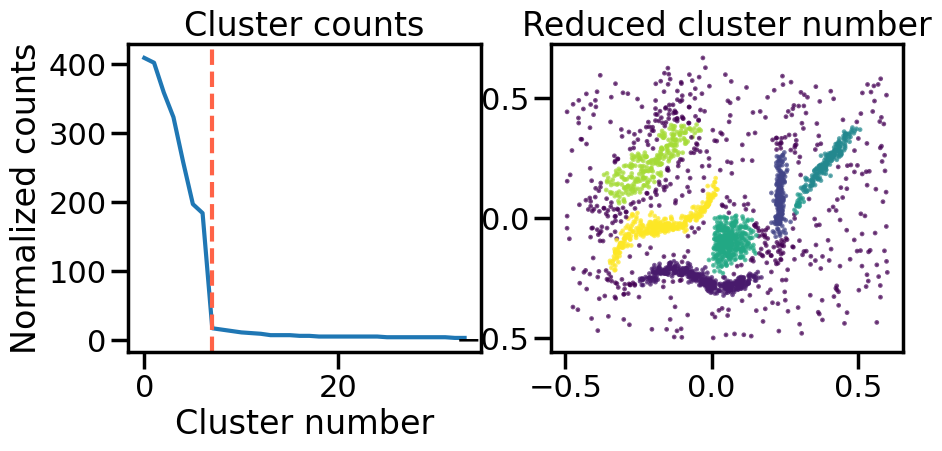

In [33]:
counts = np.unique(cluster_labels,return_counts=True)[1]
M = np.max(counts)
normal_counts = -np.sort(-counts)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(normal_counts)
ax[0].set_title("Cluster counts")
ax[0].set_xlabel("Cluster number")
ax[0].set_ylabel("Normalized counts")
ax[0].axvline(x=7,ls="--",color="tomato")

min_count = normal_counts[7]
print("Minimum cluster size : ",min_count)
counted_clusters = np.where(counts >= min_count)[0]-1
print("Counted clusters : ",counted_clusters)
reduced_cluster_labels = [cluster if cluster in counted_clusters else -1 for cluster in cluster_labels]

ax[1].scatter(points[:, 0], points[:, 1], s=2, alpha=.7,
                          c=reduced_cluster_labels)#, cmap='rainbow')
ax[1].set_title("Reduced cluster number");

**Significantly improved!**

**We could streamline the process of eliminating unwanted clusters by automatically removing those whose area falls below approximately 10% of the total curve area.**

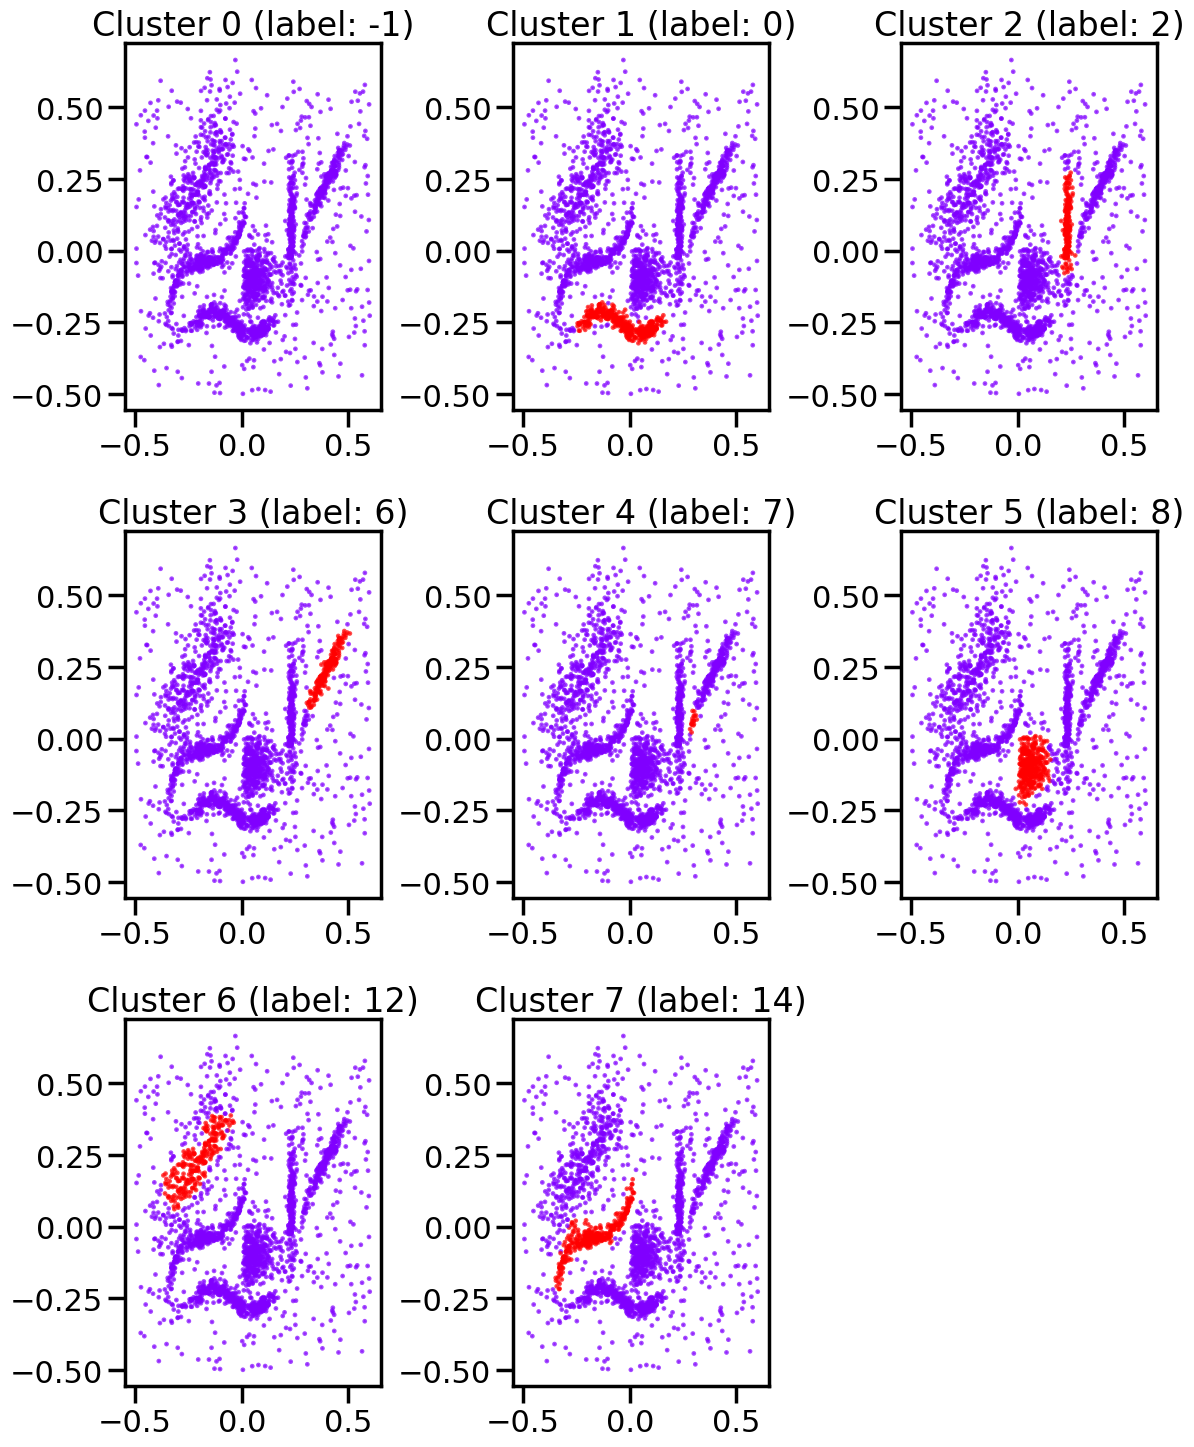

In [47]:
import matplotlib.pyplot as plt

# Function to get the cluster labels for a specific cluster
def get_cluster(k):
    reduced_cluster_labels = [cluster if cluster == k else -1 for cluster in cluster_labels]
    return reduced_cluster_labels

# Create a grid of subplots for all clusters
n_clusters = len(counted_clusters)
n_cols = 3  # Define the number of columns for the subplot grid
n_rows = (n_clusters + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))  # Adjust figure size as needed
axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

# Loop through each cluster and create a subplot
for i, k in enumerate(counted_clusters):
    axs[i].scatter(points[:, 0], points[:, 1], s=2, alpha=.7, c=get_cluster(k), cmap='rainbow')  # Plot of cluster k
    axs[i].set_title(f"Cluster {i} (label: {k})")


# Remove empty subplots if the number of clusters is less than the total subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display all plots at once


## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

Min samples tested:  [4, 10, 40]


100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


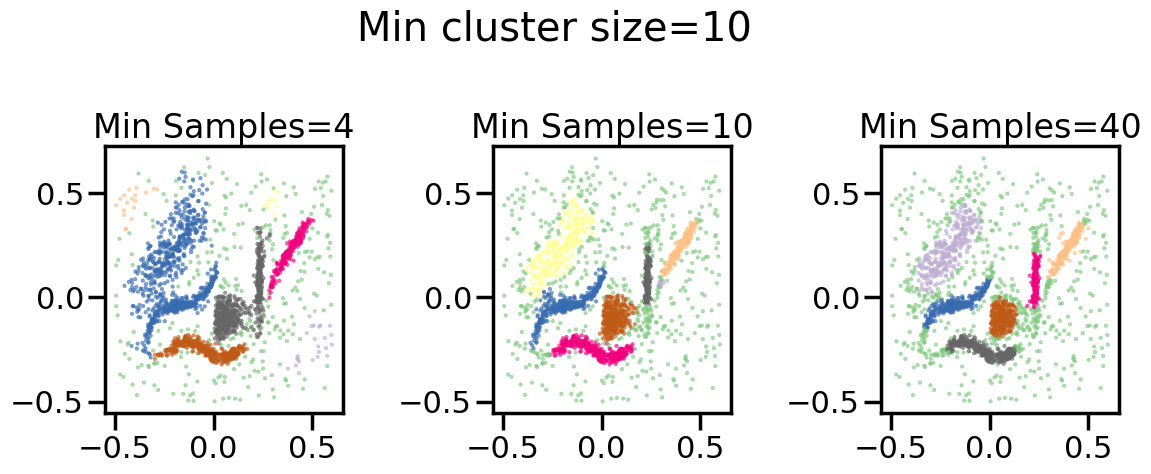

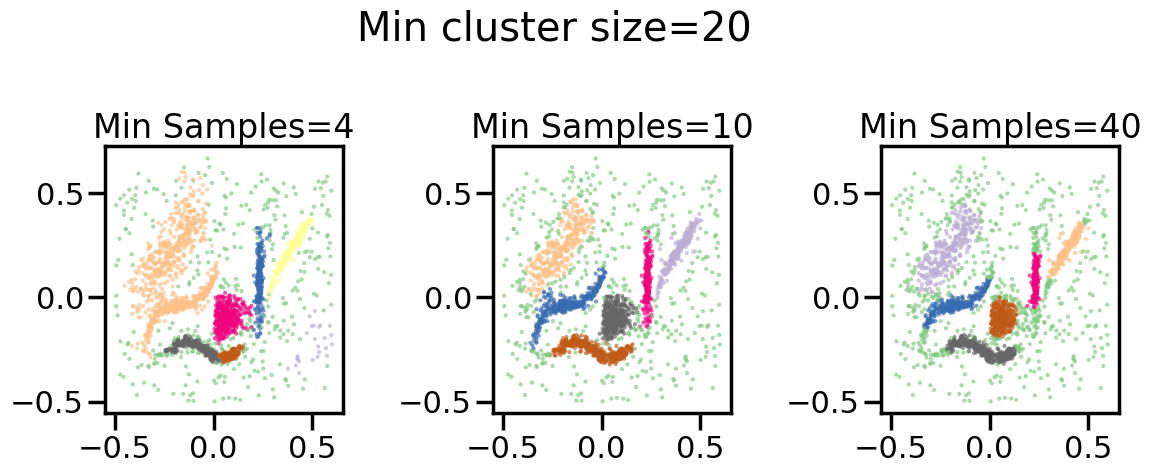

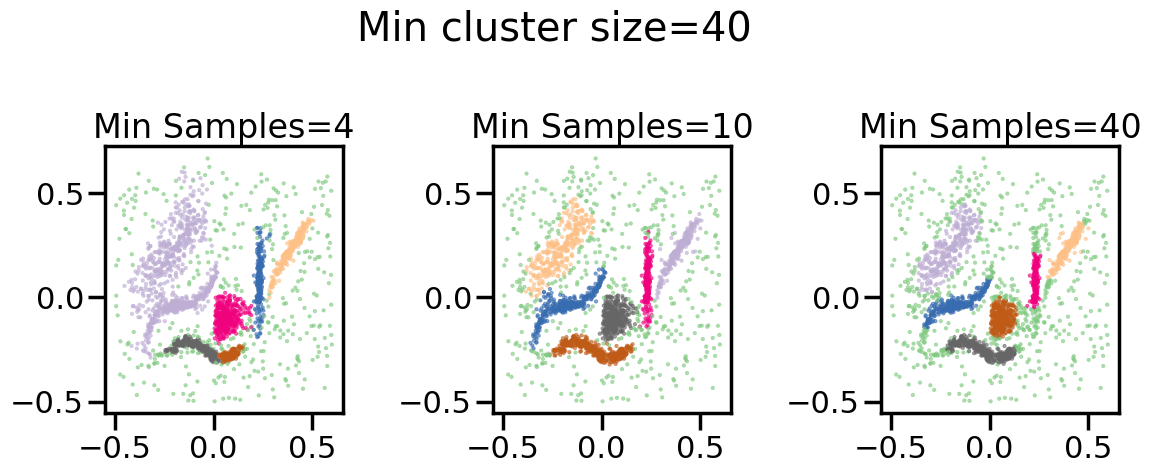

In [50]:
import hdbscan


def benchmark(points,min_samples_tested,min_cluster_size_tested,hdbscan_args,point_size=1):
    print("Min samples tested: ", min_samples_tested)

    for min_cluster_size in tqdm(min_cluster_size_tested):
        n_row_plot, n_col_plot = 1, 3
        fig, axs = plt.subplots(n_row_plot, n_col_plot,figsize=(12, 5))
        fig.suptitle("Min cluster size="+str(min_cluster_size))

        for l, min_samples in enumerate(min_samples_tested):

            hdbscan_model = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size,**hdbscan_args)
            cluster_labels = hdbscan_model.fit_predict(points)

            idx_ax_plot = (l//n_col_plot, l%n_col_plot) if (n_row_plot>1 and n_col_plot>1) else l
            axs[idx_ax_plot].scatter(points[:, 0], points[:, 1], s=point_size, alpha=.7,
                                    c=cluster_labels, cmap='Accent')

            #add legend
            axs[idx_ax_plot].set_title("Min Samples="+str(min_samples))
        fig.tight_layout()

benchmark(points=test_data_1,
          min_samples_tested= [4, 10, 40],
          min_cluster_size_tested= [10, 20, 40],
          hdbscan_args={})

**The two parameters play distinct but crucial roles in the clustering algorithm:**

- **Minimum Cluster Size**: This parameter defines the smallest number of points that can form a valid cluster. By increasing this value, we effectively raise the threshold for what is considered a legitimate cluster, leading to a greater number of points being classified as outliers. Conversely, a lower minimum cluster size allows for smaller clusters to form, which can lead to the inclusion of noise points—irregular data that does not conform to the general pattern. Given the high level of noise in our dataset, we opted to set the minimum cluster size to 20. This decision ensures that we do not unintentionally include noisy points in our clusters, preserving the integrity of our analysis. It is also crucial to note that setting this parameter too high could risk declaring all points in smaller clusters as outliers, which would diminish our ability to detect meaningful patterns in the data.

- **Minimum Samples**: This parameter specifies the number of points in a neighborhood required for a point to qualify as a core point. Core points are pivotal in defining the shape and structure of a cluster. If this value is set too high, it may lead to the exclusion of boundary points from the cluster, which could result in valuable information being lost. Observing the behavior of clusters as we varied the minimum samples between 10 and 40 revealed a noticeable erosion of clusters on the right side of the plot. This erosion indicated that a higher minimum sample count was detrimental to cluster integrity. As such, we determined that a minimum samples value of 10 strikes the right balance, allowing us to maintain the essential structure of the clusters while still effectively distinguishing between core and noise points.



## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


In [ ]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [ ]:
# TODO:
# I = 
# S = 

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [ ]:
# TODO

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [ ]:
# TODO